In [ ]:
import numpy as np
import pyafn

print("=" * 60)
print("EXAMPLE 1: Single Room with 4 Openings")
print("=" * 60)

flowParamsSet = {
    "C_d": [1, 1, 1, 1],
    "A": [1, 1, 1, 1],
    "p_w": [1, 3, 1, -3],
    "z": [3, 3, 6, 3],
    "delT": [-3, 0, 3, 0],
    "q": [1, 2, -1, -2],
    "rooms": [[1], [1], [1], [1]],
    "hr": 3  # Reference height
}

# Convert lists to numpy arrays
flowParams = {k: np.array(v) for k, v in flowParamsSet.items()}

p_0s = np.array([1])

print(f"\nGiven indoor pressure p0 = {p_0s[0]} Pa")
print("\nFlow rates through each opening (m³/s):")
print(pyafn.flowField(p_0s, pyafn.rho, flowParams))
print(f"\nContinuity residual (sum of q²): {pyafn.qObjective(p_0s, pyafn.rho, flowParams):.4f}")
print("\nCalculated discharge coefficients:")
print(pyafn.getC(p_0s, pyafn.rho, flowParams))

array([ 0.78230429,  1.80701581, -1.10634533, -2.55550626])

1.1503238194362615

array([1.27827498, 1.10679718, 0.90387691, 0.78262379])

Text(0, 0.5, '$\\sum q^2$')

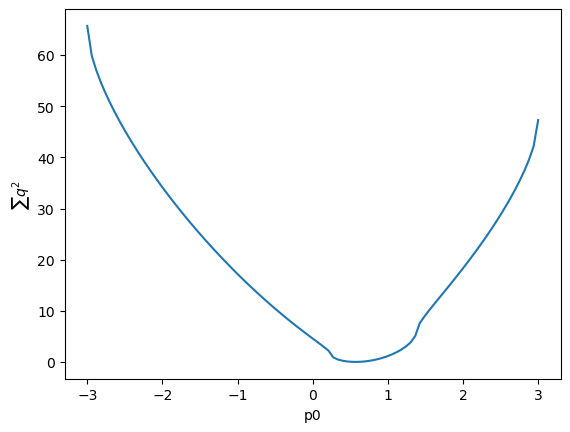

In [ ]:
import matplotlib.pyplot as plt

print("\nPlotting objective function vs. indoor pressure...")

plt.figure(figsize=(10, 6))
p0s = np.linspace(min(pyafn.getWindBuoyantP(pyafn.rho, flowParams)), 
                  max(pyafn.getWindBuoyantP(pyafn.rho, flowParams)), 100)
qs = [pyafn.qObjective(np.array([p0]), pyafn.rho, flowParams) for p0 in p0s]
plt.plot(p0s, qs, linewidth=2)
plt.xlabel("Indoor Pressure p0 (Pa)", fontsize=12)
plt.ylabel("Objective Function $\sum q^2$ (m⁶/s²)", fontsize=12)
plt.title("Continuity Residual vs. Indoor Pressure", fontsize=14)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [ ]:
print("\n" + "=" * 60)
print("Finding Optimal Indoor Pressure")
print("=" * 60)

optResults = pyafn.findOptimalP0(pyafn.rho, flowParams)
p_0s = optResults.x

print(f"\nOptimization Status: {optResults.message}")
print(f"Success: {optResults.success}")
print(f"\nOptimal indoor pressure: {p_0s[0]:.4f} Pa")
print(f"Final objective value: {optResults.fun:.6e}")

print("\nFlow rates at optimal pressure (m³/s):")
flows = pyafn.flowField(p_0s, pyafn.rho, flowParams)
print(flows)
print(f"Sum of flows: {np.sum(flows):.6e} (should be ~0 for mass balance)")

print("\nContinuity check:")
print(f"Objective (sum of q²): {pyafn.qObjective(p_0s, pyafn.rho, flowParams):.6e}")

print("\nCalculated discharge coefficients:")
print(pyafn.getC(p_0s, pyafn.rho, flowParams))

  message: CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL
  success: True
   status: 0
      fun: 1.5555604385793342e-15
        x: [ 5.706e-01]
      nit: 5
      jac: [-1.372e-07]
     nfev: 16
     njev: 8
 hess_inv: <1x1 LbfgsInvHessProduct with dtype=float64>

array([ 1.14592419,  1.99159443, -0.72308904, -2.41442954])

1.5555604385793342e-15

array([0.87265808, 1.00422052, 1.38295555, 0.82835302])

In [ ]:
print("\n" + "=" * 60)
print("Joint Optimization of Pressures and Discharge Coefficients")
print("=" * 60)
print("\nThis optimizes both p0 and C_d to match target flows")
print("while encouraging uniform discharge coefficients.\n")

# Jointly optimize pressures and discharge coefficients
flowParams = {k: np.array(v) for k, v in flowParamsSet.items()}
p_0s = np.array([1])

optResults = pyafn.findOptimalP0AndC(pyafn.rho, flowParams, weight=1e-1, disp=True)
n_rooms = flowParams["rooms"].shape[1] 
p_0s = optResults.x[0:n_rooms]
flowParams["C_d"] = optResults.x[n_rooms:]

print(f"\nOptimization Status: {optResults.message}")
print(f"Success: {optResults.success}")
print(f"\nOptimal indoor pressure: {p_0s}")
print(f"Optimal discharge coefficients: {flowParams['C_d']}")

print("\nPredicted flow rates (m³/s):")
print(pyafn.flowField(p_0s, pyafn.rho, flowParams))

print("\nBack-calculated discharge coefficients:")
print(pyafn.getC(p_0s, pyafn.rho, flowParams))

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.43358D-01    |proj g|=  1.73474D+00

At iterate    1    f=  3.64901D-02    |proj g|=  4.61089D-01

At iterate    2    f=  1.34167D-02    |proj g|=  2.38458D-01

At iterate    3    f=  8.70369D-03    |proj g|=  9.33446D-02

At iterate    4    f=  6.98965D-03    |proj g|=  7.58974D-02

At iterate    5    f=  5.73875D-03    |proj g|=  3.41759D-02

At iterate    6    f=  5.38655D-03    |proj g|=  1.45074D-02

At iterate    7    f=  5.24400D-03    |proj g|=  1.80828D-02

At iterate    8    f=  4.95994D-03    |proj g|=  2.80757D-02

At iterate    9    f=  4.60352D-03    |proj g|=  3.44025D-02

At iterate   10    f=  4.44133D-03    |proj g|=  2.32065D-02

At iterate   11    f=  4.38754D-03    |proj g|=  3.61751D-03

At iterate   12    f=  4.38288D-03    |proj g|=  1.43381D-03

At iterate   13    f=  4.3

  message: CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL
  success: True
   status: 0
      fun: 0.004382203055367082
        x: [ 7.930e-01  1.022e+00  1.052e+00  1.054e+00  8.066e-01]
      nit: 15
      jac: [ 4.783e-06  9.029e-07 -3.687e-07  6.176e-06  5.045e-06]
     nfev: 108
     njev: 18
 hess_inv: <5x5 LbfgsInvHessProduct with dtype=float64>

array([ 0.99606955,  1.99641402, -0.99249002, -2.00711785])

array([1.02600412, 1.05361584, 1.06235935, 0.80369521])

In [ ]:
print("\n" + "=" * 60)
print("EXAMPLE 2: Two Rooms with 5 Openings (1D Temperature)")
print("=" * 60)

flowParamsSet = {
    "C_d": [1, 1, 1, 1, 10],
    "A": [1, 1, 1, 1, 3],
    "p_w": [1, 3, 1, -3, 0],
    "z": [3, 3, 6, 3, 0],
    "delT": [-3, 0, 3, 0, 0],
    "q": [2, 2, -1, -3, -4],
    "rooms": [[1, 0], [1, 0], [0, 1], [0, 1], [1, -1]],
    "hr": 3  # Reference height
}

# Convert lists to numpy arrays
flowParams = {k: np.array(v) for k, v in flowParamsSet.items()}
p_0s = np.array([1, -1])

print(f"\nGiven indoor pressures: Room 1 = {p_0s[0]} Pa, Room 2 = {p_0s[1]} Pa")
print("\nFlow rates through each opening (m³/s):")
flows = pyafn.flowField(p_0s, pyafn.rho, flowParams)
print(flows)

print(f"\nContinuity residual: {pyafn.qObjective(p_0s, pyafn.rho, flowParams):.4f}")

print("\nCalculated discharge coefficients:")
print(pyafn.getC(p_0s, pyafn.rho, flowParams))

array([  0.78230429,   1.80701581,   1.42874285,  -1.80701581,
       -54.21047417])

5562.649436230062

array([ 2.55654996,  1.10679718, -0.69991602,  1.66019577,  0.73786479])

In [ ]:
print("\n" + "=" * 60)
print("EXAMPLE 3: Two Rooms with 5 Openings (2D Temperature Layers)")
print("=" * 60)
print("Temperature varies with height in each room")

flowParamsSet = {
    "C_d": [1, 1, 1, 1, 10],
    "A": [1, 1, 1, 1, 3],
    "p_w": [1, 3, 1, -3, 0],
    "z": [1.5, 4, 3, 1.5, 0],
    "delT": [[-3, -2], [0, 1], [2, 3], [0, 0], [0, 0]],
    "q": [2, 2, -1, -3, -4],
    "rooms": [[1, 0], [1, 0], [0, 1], [0, 1], [1, -1]],
    "hr": 3  # Reference height
}

# Convert lists to numpy arrays
flowParams = {k: np.array(v) for k, v in flowParamsSet.items()}
p_0s = np.array([1, -1])

print(f"\nGiven indoor pressures: Room 1 = {p_0s[0]} Pa, Room 2 = {p_0s[1]} Pa")
print("\nFlow rates through each opening (m³/s):")
flows = pyafn.flowField(p_0s, pyafn.rho, flowParams)
for i, flow in enumerate(flows):
    print(f"  Opening {i}: {flow:7.3f}")

print(f"\nContinuity residual: {pyafn.qObjective(p_0s, pyafn.rho, flowParams):.4f}")

print("\nCalculated discharge coefficients:")
Cd_calc = pyafn.getC(p_0s, pyafn.rho, flowParams)
for i, cd in enumerate(Cd_calc):
    print(f"  Opening {i}: {cd:.4f}")

array([  0.55317267,   1.75934821,   1.65991148,  -1.80701581,
       -54.21047417])

5616.2455158607145

array([ 3.61550763,  1.13678463, -0.60244176,  1.66019577,  0.73786479])

In [ ]:
print("\n" + "=" * 60)
print("Optimizing Pressures for Example 3")
print("=" * 60)

optResults = pyafn.findOptimalP0(pyafn.rho, flowParams)
p_0s = optResults.x

print(f"\nOptimization Status: {optResults.message}")
print(f"Success: {optResults.success}")

print(f"\nOptimal indoor pressures:")
print(f"  Room 1: {p_0s[0]:.4f} Pa")
print(f"  Room 2: {p_0s[1]:.4f} Pa")

print(f"\nFinal objective value: {optResults.fun:.6e}")

print("\nFlow rates at optimal pressures (m³/s):")
flows = pyafn.flowField(p_0s, pyafn.rho, flowParams)
for i, flow in enumerate(flows):
    print(f"  Opening {i}: {flow:7.3f}")

# Check mass balance for each room
rooms = flowParams["rooms"]
room_flows = np.matmul(rooms.T, flows)
print("\nMass balance check (flow into each room):")
for i, room_flow in enumerate(room_flows):
    print(f"  Room {i+1}: {room_flow:.6e} m³/s (should be ~0)")

print(f"\nContinuity residual: {pyafn.qObjective(p_0s, pyafn.rho, flowParams):.6e}")

print("\nCalculated discharge coefficients:")
Cd_calc = pyafn.getC(p_0s, pyafn.rho, flowParams)
for i, cd in enumerate(Cd_calc):
    print(f"  Opening {i}: {cd:.4f}")

  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: 1.509336608016571e-07
        x: [ 7.364e-01  7.313e-01]
      nit: 28
      jac: [ 6.489e-03 -6.222e-03]
     nfev: 174
     njev: 58
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>

array([ 0.85811675,  1.87767688, -0.2670601 , -2.46818422, -2.73552436])

1.509336608016571e-07

array([ 2.33068519,  1.06514599,  3.74447555,  1.21546843, 14.62242508])

In [ ]:
print("\n" + "=" * 60)
print("Joint Optimization of Pressures and Discharge Coefficients")
print("(Two-Room Case)")
print("=" * 60)
print("\nMatching target flows while encouraging uniform C_d values\n")

# Jointly optimize pressures and discharge coefficients (two-room case)
flowParams = {k: np.array(v) for k, v in flowParamsSet.items()}
p_0s = np.array([1, -1])

optResults = pyafn.findOptimalP0AndC(pyafn.rho, flowParams, weight=1e-1)
n_rooms = flowParams["rooms"].shape[1]
p_0s = optResults.x[0:n_rooms]
flowParams["C_d"] = optResults.x[n_rooms:]

print(f"Optimization Status: {optResults.message}")
print(f"Success: {optResults.success}")

print(f"\nOptimal indoor pressures:")
for i, p in enumerate(p_0s):
    print(f"  Room {i+1}: {p:.4f} Pa")

print(f"\nOptimal discharge coefficients:")
for i, cd in enumerate(flowParams["C_d"]):
    print(f"  Opening {i}: {cd:.4f}")

print("\nPredicted flow rates (m³/s):")
flows = pyafn.flowField(p_0s, pyafn.rho, flowParams)
for i, flow in enumerate(flows):
    print(f"  Opening {i}: {flow:7.3f}")

print("\nBack-calculated C_d (should match optimal C_d):")
Cd_calc = pyafn.getC(p_0s, pyafn.rho, flowParams)
for i, cd in enumerate(Cd_calc):
    print(f"  Opening {i}: {cd:.4f}")

  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: 0.2961650557509545
        x: [ 9.331e-01  7.756e-01  2.900e+00  1.146e+00  2.399e+00
             1.222e+00  2.605e+00]
      nit: 44
      jac: [-1.335e-04 -7.208e-05  6.106e-08  2.548e-06 -6.795e-06
            -1.771e-06 -2.139e-05]
     nfev: 480
     njev: 60
 hess_inv: <7x7 LbfgsInvHessProduct with dtype=float64>

array([ 1.86872795,  2.05076527, -0.90914394, -3.03353156, -3.96376856])

array([3.10392528, 1.11725094, 2.63839175, 1.20831597, 2.62926189])